# CNN on timeseries data
## Yoav Ram

Here, we apply convolutional neural networks to timeseries data rather than image data. 
I follow an example [Keras docs](https://keras.io/examples/timeseries/timeseries_classification_from_scratch/), but avoid looking at it before you try to solve it yourself.

You can find more details on CNNs for timeseries classification in [Wang et al. 2016](https://arxiv.org/abs/1611.06455).

**Please use the correct kernel**: in the notebook menu bar, click `Kernel`, then `Change kernel...` then choose `conda_tensorflow2_p38`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

import tensorflow as tf
import keras

print('Tensorflow:', tf.__version__)    
print('Keras:', keras.__version__)
print('GPU:', tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2024-09-04 16:11:22.155052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow: 2.13.1
Keras: 2.13.1
GPU: []



# The FordA dataset

The dataset we are using here is called [_FordA_](http://www.j-wichard.de/publications/FordPaper.pdf).
The dataset contains 3,601 training instances and another 1,320 testing instances. So it's not a very big dataset.

Each timeseries corresponds to a measurement of engine noise captured by a motor sensor. 
The goal is to detect the presence of a specific issue with the engine. It is a balanced binary classification task. 

We will use the `FordA_TRAIN` file for training and the `FordA_TEST` file for testing. 
The first column corresponds to the label.

In [2]:
root_url = "https://github.com/yoavram/cd-diagram/raw/master/FordA/"

train_data = np.loadtxt(root_url + "FordA_TRAIN.tsv", delimiter="\t")
x_train, y_train = train_data[:, 1:], train_data[:, 0].astype(int)
test_data = np.loadtxt(root_url + "FordA_TEST.tsv", delimiter="\t")
x_test, y_test = train_data[:, 1:], train_data[:, 0].astype(int)

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
timeseries_length = x_train.shape[1]
print("Good: {}, Bad: {}".format((y_train[:,0]==1).sum(), (y_train[:,0]==0).sum()))
print("Timeseries length:", timeseries_length)

Good: 1846, Bad: 1755
Timeseries length: 500


Here we visualize five example for each class in the dataset.

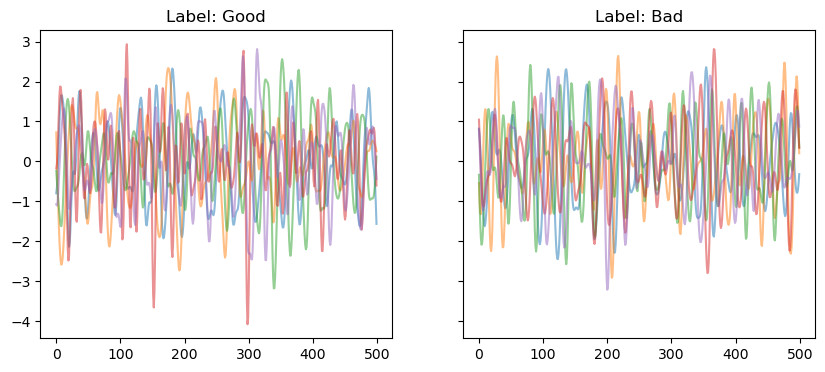

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

x_ = x_train[y_train[:,0]==1]
axes[0].plot(x_[:5].T, alpha=0.5)
axes[0].set_title("Label: Good")

x_ = x_train[y_train[:,1]==1]
axes[1].plot(x_[:5].T, alpha=0.5)
axes[1].set_title("Label: Bad");

We can see that it is not easy to discriminate visually between "good" and "bad" examples.

Note: the data is already scaled (or z-normalized): each timeseries sample has a mean equal to zero and a standard deviation equal to one. This type of normalization is very common for timeseries classification problems, see [Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

# CNN classifier

Let's build a CNN classifier like those we have seen before for images.
But this time, it will be applied to time series data.
Note that this means the convolutions are one- rather than two-dimensional.
But you still need to reshape the input to have the last "channel" dimenion.

Also note that the labels (`y_train` and `y_test`) are one-hot encoded, despite having only two classes. So either remove one of the columns in the label arrays, or use an output layer with 2 units--I used the latter.

In [9]:
model = keras.Sequential([
    keras.layers.Reshape((timeseries_length, 1), input_shape=(timeseries_length,)),
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(2, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 500, 1)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 500, 64)           256       
                                                                 
 batch_normalization_3 (Bat  (None, 500, 64)           256       
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 500, 64)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 500, 64)           12352     
                                                                 
 batch_normalization_4 (Bat  (None, 500, 64)           256       
 chNormalization)                                     

In [ ]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy", 
    metrics=["accuracy"],
)

Let's run the training. 
I suggest you use use two "callbacks":
- `ReduceLROnPlateau` reduces the learning rate when the validation loss does not decrease for 20 epochs (validation loss is computed on 20% of the training data). You can see it first decreasing on epoch 120 below.
- `EarlyStopping` stops the training when the validation loss does not decrease for 50 epochs.

In [11]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1, restore_best_weights=True),
    ]
)

Epoch 1/300


2024-09-04 11:35:10.425761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8906
2024-09-04 11:35:10.606253: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-04 11:35:11.732186: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-04 11:35:12.412016: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f52e98fe9c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-04 11:35:12.412046: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-09-04 11:35:12.418934: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-04 11:35:12.498915: I ./tensorflow/compiler/jit/device_compiler.h:

90/90 [==============================] - 5s 10ms/step - loss: 0.5928 - accuracy: 0.6927 - val_loss: 0.7412 - val_accuracy: 0.4743 - lr: 0.0010
Epoch 2/300
90/90 [==============================] - 0s 6ms/step - loss: 0.5013 - accuracy: 0.7552 - val_loss: 0.6975 - val_accuracy: 0.4979 - lr: 0.0010
Epoch 3/300
90/90 [==============================] - 0s 5ms/step - loss: 0.4517 - accuracy: 0.7653 - val_loss: 0.8045 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 4/300
90/90 [==============================] - 1s 6ms/step - loss: 0.4274 - accuracy: 0.7934 - val_loss: 0.9827 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 5/300
90/90 [==============================] - 0s 5ms/step - loss: 0.4212 - accuracy: 0.7878 - val_loss: 1.2967 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 6/300
90/90 [==============================] - 0s 5ms/step - loss: 0.4080 - accuracy: 0.7976 - val_loss: 0.7889 - val_accuracy: 0.5881 - lr: 0.0010
Epoch 7/300
90/90 [==============================] - 0s 5ms/step - loss: 0.4186 - accur

In [12]:
model.save("../data/ford_cnn.keras")
with open("../data/ford_cnn_history.p", "wb") as f:
    pickle.dump(history, f)

In [13]:
model = keras.models.load_model("../data/ford_cnn.keras")
with open("../data/ford_cnn_history.p", "rb") as f:
    history = pickle.load(f)

Let's see how the CNN model performs on the test data.

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

113/113 [==============================] - 0s 2ms/step - loss: 0.0559 - accuracy: 0.9836
Test accuracy 0.9836156368255615
Test loss 0.055862702429294586


I reached a high test accuracy - 98%.
You can see that only in the last few epochs the validation accuracy stabilized.

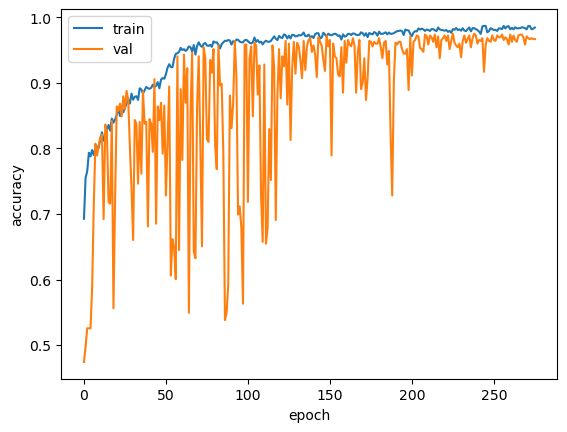

In [15]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"]);

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)